In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from tqdm import tqdm
import matplotlib.cm as cm

font = {'size'   : 12}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

# for reproducibility
np.random.seed(0) 

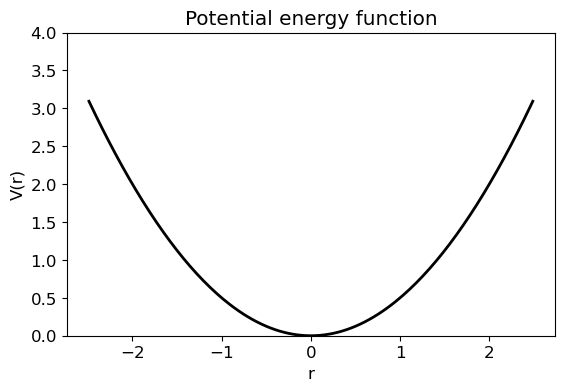

In [142]:
# System parameters
kB           = 0.008314463           # kJ mol-1 K
T            = 300                   # K
beta         = 1 / kB / T            # kJ-1 mol
M            = 1                     # amu

# Spring constant
k_spring = 1   #  N m-1  

# Angular frequency
omega    = np.sqrt(k_spring / M)

# Potential energy function kJ mol-1
r     = symbols('r')
V     = 0.5*k_spring*r**2 #( r**2 - 1 )**2  
der_V = V.diff(r)




# Convert the potential and its derivative in numpy
V     = lambdify((r), V, modules=['numpy'])
der_V = lambdify((r), der_V, modules=['numpy'])

# 1D grid for position axis
rmin     = - 2.5
rmax     = - rmin
rbins    = 200
redges   = np.linspace(rmin, rmax, rbins)
dr       = redges[1] - redges[0]
rcenters = redges + 0.5* dr
rcenters = np.delete(rcenters, -1)
rbins    = len(rcenters)

# 1D grid for momentum axis
pmin     = - 2.5
pmax     = - pmin
pbins    = 200
pedges   = np.linspace(pmin, pmax, pbins)
dp       = pedges[1] - pedges[0]
pcenters = pedges + 0.5 * dp
pcenters = np.delete(pcenters, -1)
pbins    = len(pcenters)

# 2D grid for 2D histograms
grid     = np.meshgrid(rcenters, pcenters)
rgrid    = grid[0]
pgrid    = grid[1]



fig, ax1 = plt.subplots(1, 1,figsize=(16*in2cm, 10*in2cm))  

ax1.plot(rcenters, V(rcenters), 'k', linewidth=2)
ax1.set_title('Potential energy function')
ax1.set_xlabel('r')
ax1.set_ylabel('V(r)')
ax1.set_ylim((0, 4));

### Hamiltonian dynamics

Consider a particle with mass $M>0$, momentum $p\in \Gamma_p \subset \mathbb{R}$ and position $r\in \Gamma_r \subset \mathbb{R}$, moving in a potential energy function $V(r):\Gamma_r \rightarrow \mathbb{R}$.
The hamiltonian function of the system is

\begin{equation}
H = \frac{p^2}{2M} + V(r) \, ,
\end{equation}

and the equations of motion are written as

\begin{equation}
\begin{cases}
\dot{r} &= \frac{p(t)}{M} \\
\dot{p} &= F(t) = -\nabla_r V(r(t))\\
\end{cases} \, .
\end{equation}

In the following example, we consider the potential of the harmonic oscillator

$$
V(r) = \frac{1}{2}r^2 \, .
$$


100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 41531.40it/s]


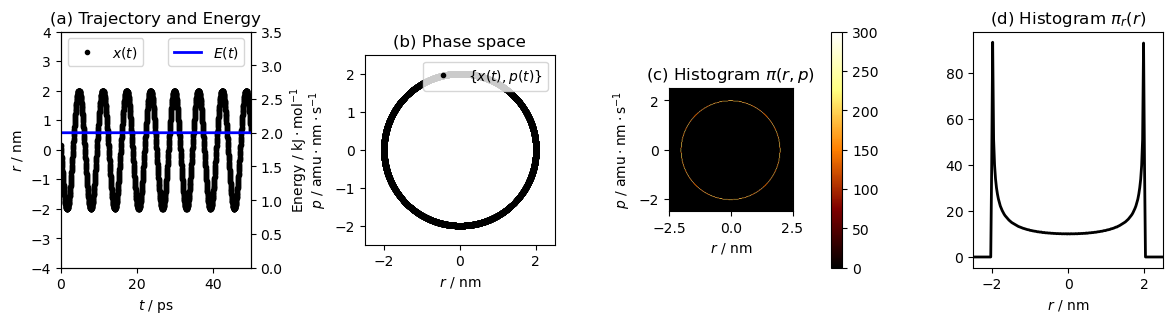

In [170]:
# Number of replicas
Nreps = 1

# Number of timesteps
Nsteps = 100000

# Integration timestep
dt = 0.02

# Time intervals
tvalues = np.linspace(0, Nsteps-1,Nsteps) * dt

# Array where to store positions
r = np.zeros((Nsteps, Nreps))

# Array where to store momenta
p = np.zeros((Nsteps, Nreps))

E      = 2

# Generate initial positions and momenta such that the total energy is E 

for i in range(Nreps):
    r0     = np.random.uniform(-E, E)
    u      = np.random.randint(0,2)
    sign   = -1 * (u==0) + 1 * (u==1)
    p0     = sign * np.sqrt( 2 * M * np.abs( E - V(r0) ) )
    r[0,i] = r0
    p[0,i] = p0

# Array where to store energy
Et = np.zeros((Nsteps, Nreps))


# Velocity Verlet integrator
for k in tqdm(range(Nsteps)):

    t = tvalues[k]
    
    r[k,:]  = r[0,:] * np.cos( omega * t ) + p[0,:] / M / omega * np.sin( omega * t )

    p[k,:]  =  - M * omega * r[0,:] * np.sin( omega * t ) + p[0,:] * np.cos( omega * t )
        
    # Total energy
    Et[k,:]  =  p[k,:] ** 2 / ( 2 * M ) + V(r[k,:])     


# Build histogram of position and momenta
hist2  =  np.histogram2d(r.flatten(), p.flatten(), bins=[redges, pedges], density = False )[0]
#hist2  =  hist2  / np.sum(hist2*dr*dp)
# Project the histogram along the momenta axis
hist1  =  np.sum(hist2 * dp, axis=1)

#np.linalg.norm(hist, ord=1, axis=1, keepdims=True)
#hist  = hist / row_norms_l1

############################################## F I G U R E


font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

fig, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4,figsize=(28*in2cm, 6*in2cm))  
ax1r = ax1.twinx()
ax1.plot(tvalues[0:10000:1], r[0:10000:1],'k.', linewidth = 2, label = r'$x(t)$')
ax1.set_xlabel(r'$t$ / ps')
ax1.set_ylabel(r'$r$ / nm')
ax1.set_title('(a) Trajectory and Energy')
ax1.set_xlim((0,50))
ax1.set_ylim((-4,4))
ax1r.plot(tvalues[0:10000:1], Et[0:10000:1,0],'b-', linewidth = 2, label = r'$E(t)$')
ax1r.set_ylabel(r'Energy / $\mathrm{kJ\cdot mol^{-1}}$')
ax1r.set_ylim((0, 3.5))

ax2.plot(r[0:10000:1], p[0:10000:1], 'k.', linewidth = 2, label = r'$\lbrace x(t), p(t)\rbrace$')
ax2.set_xlabel(r'$r$ / nm')
ax2.set_ylabel(r'$p$ / $\mathrm{amu\cdot nm \cdot s^{-1}}$')
ax2.set_title('(b) Phase space')
ax2.set_xlim((rmin, rmax))
ax2.set_ylim((pmin, pmax))
ax2.set_aspect('equal')

pos = ax3.pcolormesh(rgrid, pgrid, hist2.T,  cmap = cm.afmhot, shading='gouraud', vmin = 0, vmax = 300)
ax3.set_title(r'(c) Histogram $\pi(r,p)$')
ax3.set_xlabel(r'$r$ / nm')
ax3.set_ylabel(r'$p$ / $\mathrm{amu\cdot nm \cdot s^{-1}}$')
ax3.set_xlim((rmin, rmax))
ax3.set_ylim((pmin, pmax))
ax3.set_aspect('equal')
fig.colorbar(pos, ax=ax3, pad=0.2)

ax4.plot(rcenters, hist1, 'k-', linewidth = 2)
ax4.set_xlabel(r'$r$ / nm')
ax4.set_title(r'(d) Histogram $\pi_r(r)$')
ax4.set_xlim((rmin, rmax))

ax1.legend(loc='upper left')
ax1r.legend(loc='upper right')
ax2.legend(loc='upper right')



plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.6, hspace=0.8);
#fig.savefig('figures/isolated_prob_distr.png', format='png', dpi=900, bbox_inches='tight')